# Correlation comparison for intensity data 

In [1]:
%pylab inline
import numpy as np
import numpy.fft
import tifffile 
import sys
import multipletau as mpt #install from here: https://github.com/FCS-analysis/multipletau

def correlate_circular(a, b):
    """Return circular correlation of two vectors using DFT."""
    size = a.size

    # forward DFT
    a = np.fft.rfft(a)
    b = np.fft.rfft(b)
    # multiply by complex conjugate
    c = a * b.conj()
    # reverse DFT
    c = np.fft.irfft(c)
    
    # positive delays only
    c = c[:size // 2]
        
    # normalize with the averages of a and b
    #   c is already normalized by size
    #   the 0th value of the DFT contains the sum of the signal
    c /= a[0].real * b[0].real / size
    c -= 1.0
    
    return c
def correlate_linear(a, b):
    """Return linear correlation of two vectors using DFT."""
    size = a.size
    
    # subtract mean and pad with zeros to twice the size
    a_mean = a.mean()
    b_mean = b.mean()
    
    #Has the padding in
    a = np.pad(a-a_mean, a.size//2, mode='constant')
    b = np.pad(b-b_mean, b.size//2, mode='constant')
    
    # forward DFT
    a = np.fft.rfft(a)
    b = np.fft.rfft(b)
    # multiply by complex conjugate
    c = a * b.conj()
    # reverse DFT
    c = np.fft.irfft(c)
    # positive delays only
    c = c[:size // 2]
        
    # normalize with the averages of a and b
    c /= size * a_mean * b_mean
    
    return c


def correlate_numpy(a, b):
    """Return linear correlation of two vectors using DFT."""
    size = a.size
    
    # subtract mean and pad with zeros to twice the size
    a_mean = a.mean()
    b_mean = b.mean()
    
    #same, where 
    c = np.correlate(a-a_mean,b-b_mean,'same')
    
    # positive delays only
    c = c[size // 2:]
        
    # normalize with the averages of a and b
    c /= size*a_mean * b_mean
    return c

def correlate_python_pad(a,b):
    size = a.size
    # subtract mean and pad with zeros to twice the size
    a_mean = a.mean()
    b_mean = b.mean()
    bint = np.zeros(size*2)
    bint[:size] = b
    a = np.pad(a-a_mean, a.size//2, mode='constant')
    b = np.pad(b-b_mean, b.size//2, mode='constant')
    
    mlag = size//2
   
    c = []
    for lag in range(0,size):
        c.append(np.sum(b[size//2:-size//2]*a[lag:size+lag]))
    
    # positive delays only
    c = c[size // 2:]
        
    # normalize with the averages of a and b
    c /= size*a_mean * b_mean
    return c
def correlate_python_valid(a,b):
    size = a.size
    # subtract mean and pad with zeros to twice the size
    
    
    
    
    
    mlag = size//2
   
    c = []
    atrip =  a
    atrip_mu = np.average(atrip)
    btrip = b
    btrip_mu = np.average(btrip)
    c.append(np.sum((atrip-atrip_mu)*(btrip-btrip_mu))/(size*atrip_mu*btrip_mu))
    for lag in range(1,mlag):
        
        atrip =  a[lag:]
        atrip_mu = np.average(atrip)
        btrip = b[:-lag]
        btrip_mu = np.average(btrip)
        c.append(np.sum((atrip-atrip_mu)*(btrip-btrip_mu))/(size*atrip_mu*btrip_mu))
    
    
    return c


input_data = tifffile.imread('/Users/dwaithe/Documents/collaborators/EggelingC/FCS_experiments/fcs_simulation_data/scanPaper/intensity_carpets/out_img_D_1p0_noi_0_drift_False_ts_30000_mol_120_bleach_False_prob_0_1_.tif')
a= input_data[:,0]
b= input_data[:,0]

##All this functions give normalised outputs.

print 'Circular correlate (GREEN)'
%time cccor = correlate_circular(a,b)#correlate circular
print 'Circular correlate but corrected (RED)'
%time clcor = correlate_linear(a,b)#correlate linear
print 'Linear correlate but corrected (BLACK)'
%time cncor = correlate_numpy(a,b)#correlate linear
print 'python correlate with padding (BLUE)'
%time cppcor = correlate_python_pad(a,b)#correlate linear with padding
print 'python correlate with valid (grey)'
%time cpvcor = correlate_python_valid(a,b)#correlate linear with valid
print 'python multiple-tau (red dots)'
%time mtcor = mpt.correlate(a,b,normalize=True)#correlate linear



Populating the interactive namespace from numpy and matplotlib
Circular correlate (GREEN)
CPU times: user 4.6 ms, sys: 1.15 ms, total: 5.75 ms
Wall time: 5.98 ms
Circular correlate but corrected (RED)
CPU times: user 9.13 ms, sys: 2.1 ms, total: 11.2 ms
Wall time: 11.3 ms
Linear correlate but corrected (BLACK)
CPU times: user 874 ms, sys: 3.95 ms, total: 878 ms
Wall time: 882 ms
python correlate with padding (BLUE)
CPU times: user 3.43 s, sys: 26.4 ms, total: 3.46 s
Wall time: 3.47 s
python correlate with valid (grey)
CPU times: user 22.5 s, sys: 90.5 ms, total: 22.6 s
Wall time: 22.6 s
python multiple-tau (red dots)
CPU times: user 4.26 ms, sys: 204 µs, total: 4.46 ms
Wall time: 4.47 ms


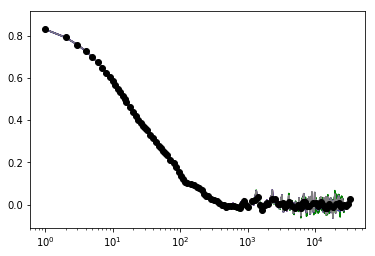

In [2]:
#Visualise outputs
semilogx(cccor, 'g')
semilogx(clcor,'r')
semilogx(cncor,'k')
semilogx(cppcor,'b')
semilogx(cpvcor,'grey')
semilogx(mtcor[:,0],mtcor[:,1],'ko')